In [1]:
import re
import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Dense, Dropout, Activation
#from scikeras.wrappers import KerasClassifier  # Updated import for Scikeras wrapper

from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Rest of your code here...


In [2]:
train_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/train.csv").fillna(' ')
train_df.head()

,id,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [3]:
train_df.describe()

,id,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,9.024365e+05,1.030173e-01,4.582099e-03,1.387721e-02,9.311271e-03,8.115273e-02,2.263571e-02,6.605974e-03
std,5.210224e+05,1.970757e-01,2.286128e-02,6.460419e-02,4.942218e-02,1.760657e-01,7.873156e-02,4.529782e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.512182e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.024365e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.353655e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000e+00
max,1.804873e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv").fillna(' ') #fill missing values with space
test_df.head(10)

,id,text
0,0,[ Integrity means that you pay your debts.]\n\...
1,1,This is malfeasance by the Administrator and t...
2,2,@Rmiller101 - Spoken like a true elitist. But ...
3,3,"Paul: Thank you for your kind words. I do, in..."
4,4,Sorry you missed high school. Eisenhower sent ...
5,5,Let’s see if I understand this; Berkowitz anno...
6,6,Our oils read; President IS taking different ...
7,7,'Work together'? Dream on. The liberals are al...
8,8,What would Jerry Prevo think about that story?...
9,9,When wil the indigenous be accountable and t...


In [5]:
test_df.describe()

,id
count,97320.000000
mean,48659.500000
std,28094.008436
min,0.000000
25%,24329.750000
50%,48659.500000
75%,72989.250000
max,97319.000000


In [6]:
test_df.info

<bound method DataFrame.info of           id                                               text
0          0  [ Integrity means that you pay your debts.]\n\...
1          1  This is malfeasance by the Administrator and t...
2          2  @Rmiller101 - Spoken like a true elitist. But ...
3          3  Paul: Thank you for your kind words.  I do, in...
4          4  Sorry you missed high school. Eisenhower sent ...
...      ...                                                ...
97315  97315  He should lose his job for promoting mis-infor...
97316  97316  "Thinning project is meant to lower fire dange...
97317  97317  I hope you millennials are happy that you put ...
97318  97318  I'm thinking Kellyanne Conway (a.k.a. The Trum...
97319  97319  I still can't figure why a pizza in AK cost mo...

[97320 rows x 2 columns]>

In [7]:
print("Training data shape: ",train_df.shape)
print("Testing data shape: ",test_df.shape)

Training data shape:  (1804874, 9)
Testing data shape:  (97320, 2)


In [8]:
train_df  = train_df.drop(['id'],axis = 1)
test_df   = test_df.drop(['id'],axis = 1)

In [9]:
null_tr = train_df.isnull().sum()
print("Null values in training set: ")
print(null_tr)
print()
null_test = test_df.isnull().sum()
print("Null values in testing set: ")
print( null_test)
print()

Null values in training set: 
text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

Null values in testing set: 
text    0
dtype: int64



In [10]:
def clean_text(line):

    clean_t = ""
    line = line.replace("’", "")  #replace these symbols with spaces(" ") or no space("")
    line = line.replace("'", "")
    line = line.replace("=", "")
    line = line.replace("-", " ")
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_t += char
        else:
            clean_t += ' '

    clean_t = re.sub(' +',' ',clean_t) #delete extra spaces

    return clean_t

In [11]:
# clean text
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text']  = test_df['text'].apply(lambda x: clean_text(x))

In [12]:
x = train_df["text"].values
print(x)

['this is so cool its like would you want your mother to read this really great idea well done '
 'thank you this would make my life a lot less anxiety inducing keep it up and dont let anyone get in your way '
 'this is such an urgent design problem kudos to you for taking it on very impressive '
 ... 'thank you right or wrong i am following your advice'
 'anyone who is quoted as having the following exchange even if apocryphal would have received my vote bessie braddock winston you are drunk and whats more you are disgustingly drunk winston churchill bessie my dear you are ugly and whats more you are disgustingly ugly but tomorrow i shall be sober and you will still be disgustingly ugly '
 'students defined as ebd are legally just as disabled and eligible for special services as a developmentally disabled or physically disabled student emotional and behavioral disorder ebd definition an emotional and behavioral disorder is an emotional disability characterized by the following i an in

In [13]:
list_class = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack","sexual_explicit"]
y = train_df[list_class].values
print(y)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.6212121  0.03030303 0.03030303 ... 0.6212121  0.04545455 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [14]:
x_test = test_df['text'].values
print(x_test)

[' integrity means that you pay your debts does this apply to president trump too '
 'this is malfeasance by the administrator and the board they are wasting our money '
 ' rmiller spoken like a true elitist but look out bud the re awakening in europe brexit and now the trump victory are just the beginning the unwashed masses are coming for you and your ilk '
 ...
 'i hope you millennials are happy that you put this airhead in charge '
 'im thinking kellyanne conway a k a the trump whisperer will play a very large role in the trump administration and as crazy as this sounds that might be a good thing '
 'i still cant figure why a pizza in ak cost more than a pizza in washington idaho kentucky etc etc the only answer i get is shipping charges i guess costco does not incur a shipping charge because there is no price difference if i am going to be charged extra at least the tv commercials for ak should show the actual prices i sure as heck dont make anymore income here than i do in wa soc

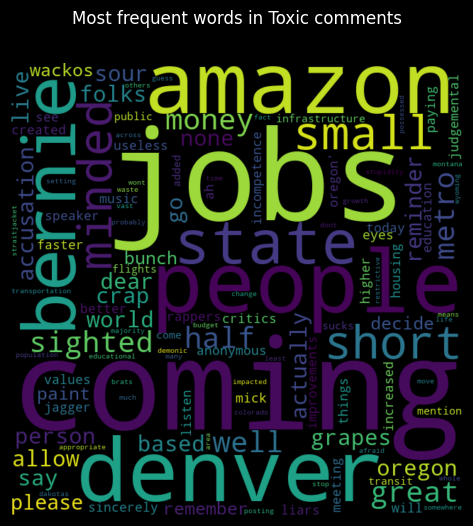

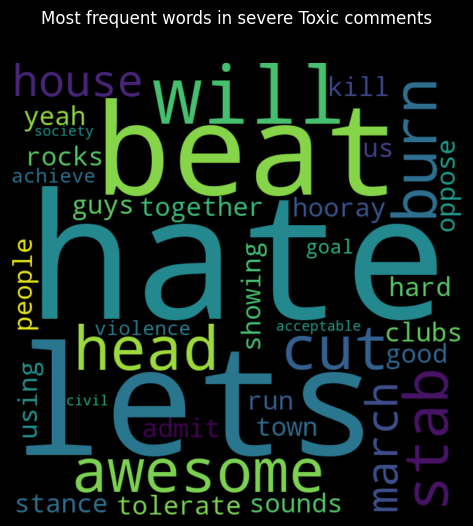

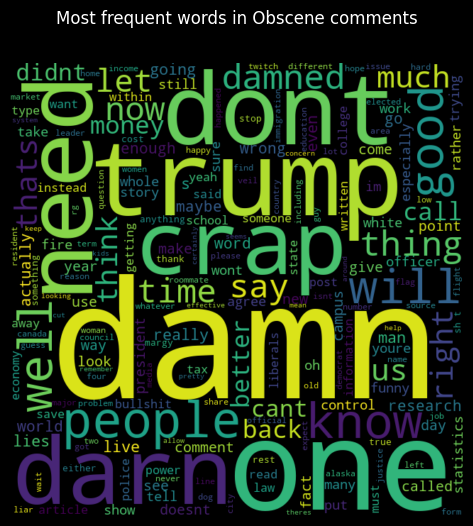

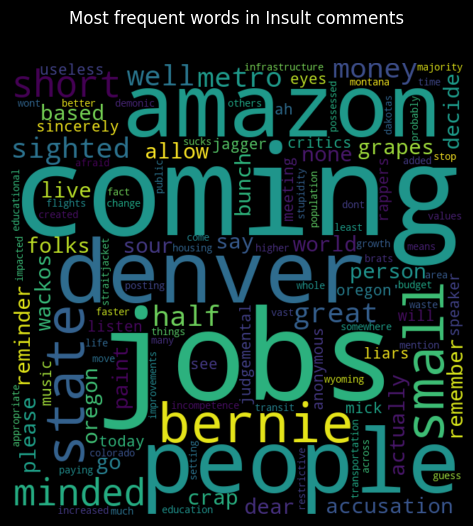

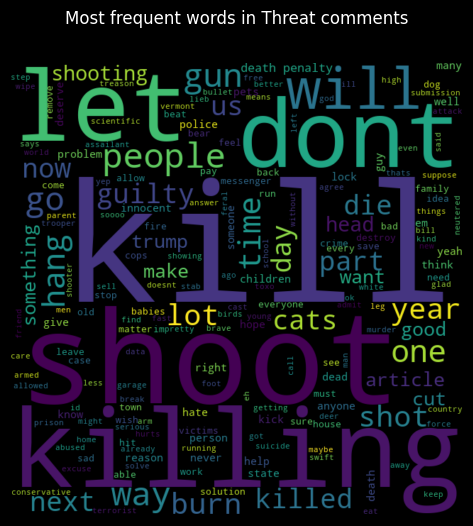

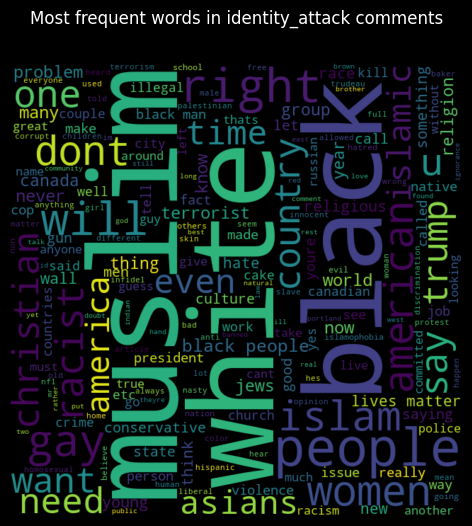

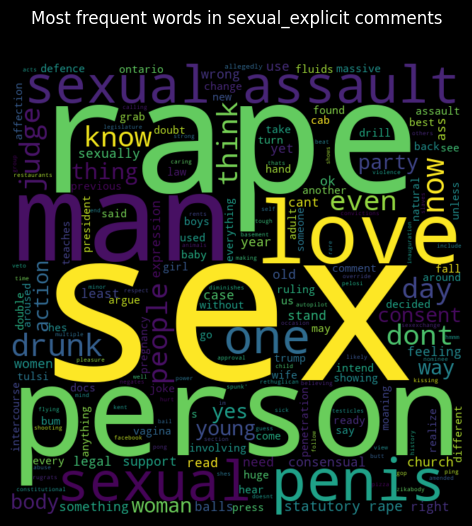

In [15]:
def word_plot(column,text):
    
    comments = train_df['text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
word_plot(train_df['toxicity'], "Toxic comments")
word_plot(train_df['severe_toxicity'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['threat'],"Threat comments")
word_plot(train_df['identity_attack'],"identity_attack comments")
word_plot(train_df['sexual_explicit'],"sexual_explicit comments")

In [16]:
#Count words
count_word = train_df["text"].apply(lambda x: len(str(x).split()))

#Unique word count
count_unique_word = train_df["text"].apply(lambda x: len(set(str(x).split())))

In [17]:
unique_percent = count_unique_word*100/count_word
unique_percent

0           94.736842
1          100.000000
2          100.000000
3           94.117647
4          100.000000
              ...    
1804869     86.486486
1804870    100.000000
1804871    100.000000
1804872     65.517241
1804873     71.755725
Name: text, Length: 1804874, dtype: float64

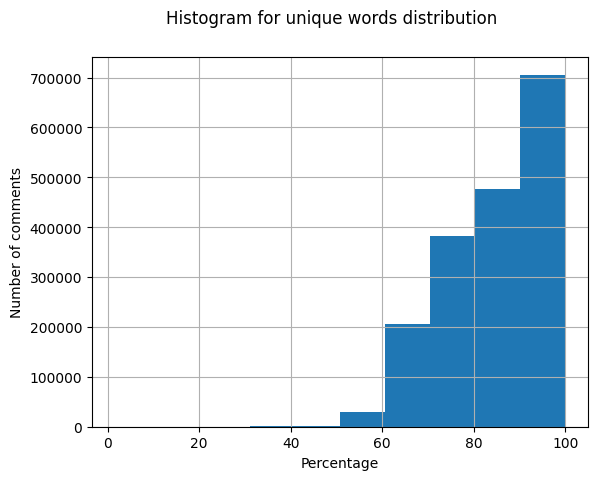

In [18]:
unique_percent.hist()
plt.suptitle("Histogram for unique words distribution")
plt.xlabel("Percentage")
plt.ylabel("Number of comments")
plt.show()

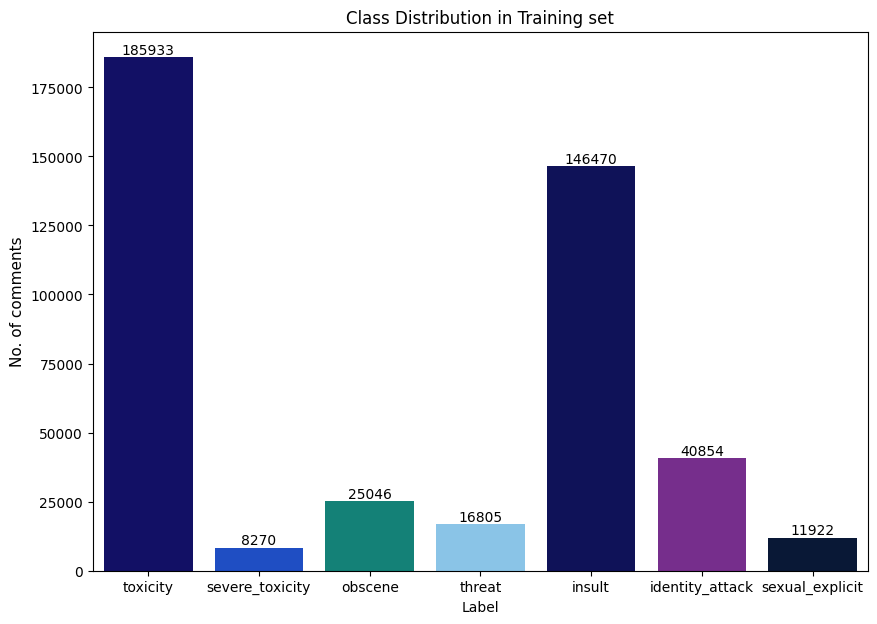

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure colors are correctly mapped from xkcd palette
colors_ = ["deep blue", "blue", "teal", "lightblue", "darkblue", "purple", "navy"]
palette = sns.xkcd_palette(colors_)

# Sum the values in your train_df (assuming it is categorical or binary)
x = train_df.iloc[:, 1:].sum()

# Create a bar plot
plt.figure(figsize=(10,7))
ax = sns.barplot(x=x.index, y=x.values, palette=palette)

# Set plot title and labels
plt.title("Class Distribution in Training set")
plt.xlabel('Label')
plt.ylabel('No. of comments', fontsize=11)

# Add the value labels on top of the bars
patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    # Place the labels a little above the top of each bar to avoid overlap
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, int(label), va='bottom', ha='center')

# Display the plot
plt.show()


/tmp/ipykernel_23/2635369167.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


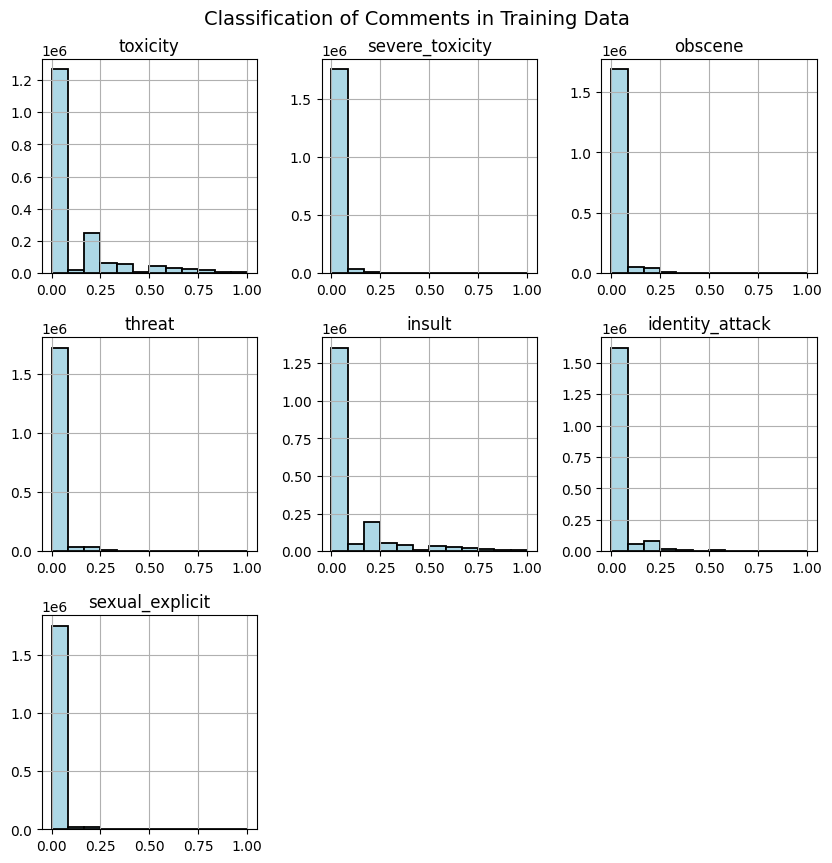

In [20]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

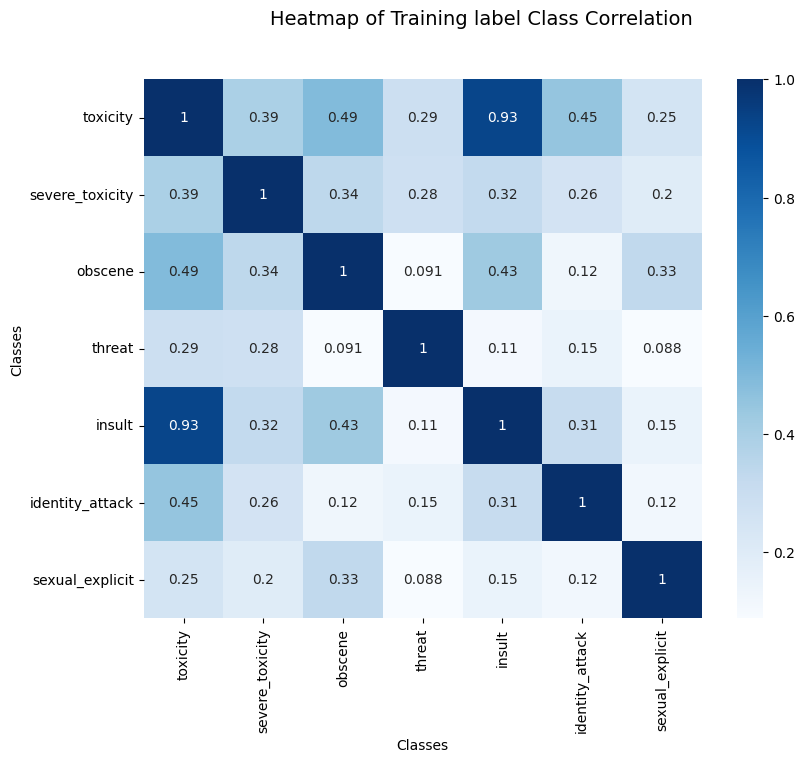

In [21]:
train_df_no_text = train_df.drop(columns=['text'])

fig = plt.figure(figsize = (9,7))
sns.heatmap(train_df_no_text.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

In [22]:
x=train_df['text']

In [23]:
max_features = 20000 # most freq 20k words in the dataset would be kept
max_text_length = 400

In [24]:
# change each text into a sequence of integers, each integer being index of token in a dictionary
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized,maxlen = max_text_length)#padding

In [25]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen = max_text_length) 

In [26]:
embedding_dim = 300
embeddings_index = dict()

# Open the GloVe file with UTF-8 encoding
with open('/kaggle/input/glove300/glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')  # Store all except values[0]
        embeddings_index[word] = coefs  # Populate embedding dict

print(f'Found {len(embeddings_index)} word vectors')


Found 1917494 word vectors


In [27]:
embedding_matrix = np.zeros((max_features,embedding_dim))

for word,index in x_tokenizer.word_index.items():
    
    if index> max_features -1: #bounding by max feat
        break
    else:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.20838    -0.14932001 -0.017528   ... -0.54066002  0.21199
  -0.0094357 ]
 [-0.24837001 -0.45460999  0.039227   ...  0.053097    0.15458
  -0.38053   ]
 ...
 [ 0.54639     0.022349   -0.41174001 ... -0.14448    -0.058237
   0.26306999]
 [-0.59443003 -0.58939999 -0.032646   ...  0.30943999  0.0025059
   0.11045   ]
 [-0.33261001 -0.14929999 -0.093908   ... -0.033626    0.85197997
  -0.095104  ]]


In [29]:
embedding_matrix.shape

(20000, 300)

In [30]:
x_train_val 

array([[   0,    0,    0, ...,  359,   90,  217],
       [   0,    0,    0, ...,    7,   35,   96],
       [   0,    0,    0, ...,   16,  101, 4912],
       ...,
       [   0,    0,    0, ..., 1090,   35, 1781],
       [   0,    0,    0, ...,  130,   15, 2529],
       [   0,    0,    0, ...,   11,    5,  498]], dtype=int32)

In [31]:
print(x_train_val.shape, y.shape)

(1804874, 400) (1804874, 7)


In [32]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y,
                                              test_size = 0.2,
                                              shuffle = True,
                                              random_state = 1)

In [33]:
print("Training Data Shape: ")
print(x_train.shape, y_train.shape)

Training Data Shape: 
(1443899, 400) (1443899, 7)


In [34]:
print("Validation Data Shape: ")
print(x_val.shape, y_val.shape)

Validation Data Shape: 
(360975, 400) (360975, 7)


In [35]:
# parameter settings
filters = 250
kernel_size = 3
hidden_dims = 250
batch_size = 32
n_epochs = 4
actfn = 'relu'
optimizer_ = tf.optimizers.SGD
drop_rate = 0.4
learningrate = 0.02

In [36]:
# function to build the model 
def model_final():
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False
                       ,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))    
    # 1st dropout
    model.add(Dropout(0.4))
    
    # 1st convolutional 1-D layer
    model.add(Conv1D(250, 3, padding = 'valid')) #no padding
    
    #max pooling layer
    model.add(MaxPooling1D())
    
    # 2nd convolutional 1-D layer
    model.add(Conv1D(250, 5, padding = 'valid', activation = 'relu'))
    
    # global max pooling layer
    model.add(GlobalMaxPooling1D())
    
    # 1st dense layer
    model.add(Dense(250,activation = 'relu'))
    
    # 2nd dropout
    model.add(Dropout(0.5))
    
    # final dense layer
    model.add(Dense(7,activation = 'sigmoid'))
    
    # compile the model
    model.compile(loss = 'mean_squared_error',    #since we are doing binary classification
                 optimizer = optimizer_(learning_rate = 0.02),
                 metrics = ['accuracy']) 

    return model

In [37]:
model = model_final()
    
# fit the model
history = model.fit(x_train,y_train,
              batch_size = batch_size,
              epochs = n_epochs,
              validation_data=(x_val,y_val))

Epoch 1/4


I0000 00:00:1731742055.192486      71 service.cc:145] XLA service 0x7b6da80074c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731742055.192548      71 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   24/45122 ━━━━━━━━━━━━━━━━━━━━ 5:25 7ms/step - accuracy: 0.1202 - loss: 0.1367

I0000 00:00:1731742059.225475      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45122/45122 ━━━━━━━━━━━━━━━━━━━━ 354s 8ms/step - accuracy: 0.6310 - loss: 0.0148 - val_accuracy: 0.9639 - val_loss: 0.0104
Epoch 2/4
45122/45122 ━━━━━━━━━━━━━━━━━━━━ 342s 8ms/step - accuracy: 0.8686 - loss: 0.0103 - val_accuracy: 0.9700 - val_loss: 0.0104
Epoch 3/4
45122/45122 ━━━━━━━━━━━━━━━━━━━━ 342s 8ms/step - accuracy: 0.9224 - loss: 0.0089 - val_accuracy: 0.9694 - val_loss: 0.0088
Epoch 4/4
45122/45122 ━━━━━━━━━━━━━━━━━━━━ 340s 8ms/step - accuracy: 0.9147 - loss: 0.0081 - val_accuracy: 0.9694 - val_loss: 0.0087


In [38]:
# Evaluate the model on validation data
score = model.evaluate(x_val, y_val, batch_size=batch_size)

print(f'Loss: {score[0]}, Accuracy: {score[1]}')


11281/11281 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9694 - loss: 0.0087
Loss: 0.008694610558450222, Accuracy: 0.9693690538406372


In [39]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import text, sequence

# Parameters from training
max_features = 20000  # Most frequent 20k words in the dataset
max_text_length = 400

# Load the test dataset
test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv")

# Tokenize and pad the test data using x_tokenizer
x_test = test_df['text']  # Replace 'text' with the column containing text in your test dataset
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)  # Use x_tokenizer from training
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

# Make predictions using the trained model
predictions = model.predict(x_testing)

# Convert predictions to binary outputs (e.g., threshold = 0.5)
binary_predictions = (predictions > 0.5).astype(int)

# Create a DataFrame for submission
submission_df = test_df[['id']].copy()  # Assuming 'id' column exists in test.csv
submission_df[['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity attack','sexual explicit']] = binary_predictions

# Save predictions to CSV
submission_df.to_csv("submission.csv", index=False)

print("Predictions saved to 'submission.csv'")


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Predictions saved to 'submission.csv'
